In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
#import the dataset with user profiles and ratings
df_in = pd.read_csv('sciencepapers_with_userprofiles.csv')

In [3]:
df_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2294 entries, 0 to 2293
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user              2294 non-null   int64  
 1   Area of interest  2294 non-null   object 
 2   Input             2294 non-null   object 
 3   title             2294 non-null   object 
 4   rating            2286 non-null   float64
 5   arxiv_id          2294 non-null   object 
 6   paperId           2294 non-null   object 
 7   created           2294 non-null   object 
 8   categories        2292 non-null   object 
 9   authors           2294 non-null   object 
 10  keywords          2294 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 197.3+ KB


In [4]:
#fill the missing rating values using the median value 3
df_in.rating = df_in.rating.fillna(3).astype(int)
df_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2294 entries, 0 to 2293
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   user              2294 non-null   int64 
 1   Area of interest  2294 non-null   object
 2   Input             2294 non-null   object
 3   title             2294 non-null   object
 4   rating            2294 non-null   int64 
 5   arxiv_id          2294 non-null   object
 6   paperId           2294 non-null   object
 7   created           2294 non-null   object
 8   categories        2292 non-null   object
 9   authors           2294 non-null   object
 10  keywords          2294 non-null   object
dtypes: int64(2), object(9)
memory usage: 197.3+ KB


In [5]:
#getting the columns we need in a list 
rating_cols = ['user','paperId','rating'] 
rating =  df_in[rating_cols]
rating

,user,paperId,rating
0,1,7051457,5
1,1,10050214,1
2,1,7051453,3
3,1,7043501,2
4,1,8092686,3
...,...,...,...
2289,222,12023461,3
2290,222,10074602,3
2291,222,180609339,2
2292,222,1610065,2


In [6]:
n_uniq_users = rating['user'].nunique()
n_uniq_papers = rating['paperId'].nunique()
print('number of unique users in the dataset :',n_uniq_users)
print('number of unique science papers in the dataset :',n_uniq_papers)

number of unique users in the dataset : 222
number of unique science papers in the dataset : 592


# Data preparation for the RBM implementation

In order to implement the RBM model, we will need a symmetrical sample size of the papers and the users.

Hence we will come up with something like a inner id implementation - like an internal mapping to identify papers and users.

In [7]:
#lets us process the paperId column first followed by the users

In [8]:
#first we will group the dataset based on the paperIds with highest ratings and take the top 100 indexes
paperIndex = rating.groupby("paperId").count().sort_values(by="rating",ascending=False)[0:200].index

#get the paper detaols from ratings dataframe
paperIndex_details = rating[rating.paperId.isin(paperIndex)]
paperIndex_details

,user,paperId,rating
3,1,7043501,2
4,1,8092686,3
5,1,14112855,3
6,1,170108029,4
7,1,9041299,3
...,...,...,...
2289,222,12023461,3
2290,222,10074602,3
2291,222,180609339,2
2292,222,1610065,2


In [9]:
#do the same for users but from the papers we selected earlier
userIndex = paperIndex_details.groupby("user").count().sort_values(by="rating",ascending=False).sample(n=200, random_state=2018).index
#get the user details from the rating dataframe
userIndex_details = paperIndex_details[paperIndex_details.user.isin(userIndex)]
userIndex_details

,user,paperId,rating
3,1,7043501,2
4,1,8092686,3
5,1,14112855,3
6,1,170108029,4
7,1,9041299,3
...,...,...,...
2289,222,12023461,3
2290,222,10074602,3
2291,222,180609339,2
2292,222,1610065,2


In [10]:
#make up the new inner iids for papers
papers = userIndex_details.paperId.unique()
papersDF = pd.DataFrame(data=papers,columns=['originalPaperId'])
papersDF['paper_iid'] = papersDF.index+1

#make up the new inner iids for users
users = userIndex_details.user.unique()
usersDF = pd.DataFrame(data=users,columns=['originalUserId'])
usersDF['user_iid'] = usersDF.index+1


In [11]:
#prepare the rbm dataset by merging the datasets we have made thus far.


rbm_dataset = userIndex_details.merge(papersDF,left_on='paperId',right_on='originalPaperId')
rbm_dataset.drop(labels='originalPaperId', axis=1, inplace=True)

rbm_dataset = rbm_dataset.merge(usersDF,left_on='user',right_on='originalUserId')
rbm_dataset.drop(labels='originalUserId', axis=1, inplace=True)

rbm_dataset.head()

,user,paperId,rating,paper_iid,user_iid
0,1,7043501,2,1,1
1,1,8092686,3,2,1
2,1,14112855,3,3,1
3,1,170108029,4,4,1
4,1,170108029,5,4,1


In [12]:
#check the users and paper samples now
n_uniq_users = rbm_dataset['user'].nunique()
n_uniq_papers = rbm_dataset['paperId'].nunique()
print('number of unique users in the dataset :',n_uniq_users)
print('number of unique science papers in the dataset :',n_uniq_papers)

number of unique users in the dataset : 200
number of unique science papers in the dataset : 200


Now we have a balanced dataset with 200 unique users and 200 unique papers.

# Building the model and testing the accuracy for 100 samples

In [13]:
#split the dataset
train, test = train_test_split(rbm_dataset, test_size=0.20, shuffle=True, random_state=2018)
validation, test = train_test_split(test, test_size=0.50, shuffle=True, random_state=2018)

In [14]:
print('length of training set',len(train))
print('length of test set',len(test))
print('length of validation set',len(validation))

length of training set 1088
length of test set 136
length of validation set 136


In [15]:
RBM_train = np.zeros((n_uniq_users, n_uniq_papers))
for row in train.itertuples():
    print(row)
    RBM_train[row[5]-1, row[4]-1] = row[3]
    print('EOR')

Pandas(Index=357, user=100, paperId='14017733', rating=3, paper_iid=42, user_iid=90)
EOR
Pandas(Index=839, user=50, paperId='181210937', rating=4, paper_iid=78, user_iid=46)
EOR
Pandas(Index=41, user=194, paperId='160600996', rating=4, paper_iid=27, user_iid=174)
EOR
Pandas(Index=987, user=18, paperId='160808112', rating=4, paper_iid=106, user_iid=18)
EOR
Pandas(Index=601, user=150, paperId='171104595', rating=2, paper_iid=46, user_iid=139)
EOR
Pandas(Index=213, user=4, paperId='18110166', rating=2, paper_iid=26, user_iid=4)
EOR
Pandas(Index=651, user=9, paperId='10013663', rating=3, paper_iid=57, user_iid=9)
EOR
Pandas(Index=250, user=97, paperId='180904284', rating=4, paper_iid=23, user_iid=87)
EOR
Pandas(Index=794, user=127, paperId='13104802', rating=2, paper_iid=112, user_iid=117)
EOR
Pandas(Index=93, user=141, paperId='8092686', rating=3, paper_iid=2, user_iid=130)
EOR
Pandas(Index=1223, user=35, paperId='171207705', rating=1, paper_iid=141, user_iid=34)
EOR
Pandas(Index=815, use

Pandas(Index=270, user=99, paperId='12030061', rating=4, paper_iid=52, user_iid=89)
EOR
Pandas(Index=612, user=176, paperId='180510511', rating=3, paper_iid=173, user_iid=159)
EOR
Pandas(Index=758, user=12, paperId='150906836', rating=2, paper_iid=74, user_iid=12)
EOR
Pandas(Index=687, user=205, paperId='180706996', rating=5, paper_iid=53, user_iid=183)
EOR
Pandas(Index=123, user=84, paperId='150308482', rating=4, paper_iid=192, user_iid=75)
EOR
Pandas(Index=1050, user=21, paperId='160106296', rating=4, paper_iid=119, user_iid=21)
EOR
Pandas(Index=683, user=199, paperId='18060127', rating=3, paper_iid=198, user_iid=177)
EOR
Pandas(Index=1024, user=126, paperId='180104437', rating=5, paper_iid=102, user_iid=116)
EOR
Pandas(Index=1147, user=219, paperId='13105254', rating=3, paper_iid=149, user_iid=197)
EOR
Pandas(Index=1069, user=128, paperId='14067367', rating=2, paper_iid=118, user_iid=118)
EOR
Pandas(Index=47, user=26, paperId='14112855', rating=2, paper_iid=3, user_iid=25)
EOR
Panda

In [16]:
#calculate the sparsity for our 100 sample dataset
sparsity = float(len(RBM_train.nonzero()[0]))
sparsity /= (RBM_train.shape[0] * RBM_train.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 2.66%


# Building the RBM class
The following RBM class is part of the book,

Hands-On Unsupervised Learning Using Python: How to Build Applied Machine learning solutions from unlabeled data.
Author: Ankur A.Patel.

We have used the code to learn the implementation of RBM  and to test the efficacy of the model on our dataset.

Acknowledgements to the original author.

In [17]:
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size  #input size of the RBM
        self._output_size = output_size #output size of the RBM
        self.learning_rate = learning_rate
        self.epochs = epochs #number of epochs to train for
        self.batchsize = batchsize
        
        # Initialize weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], dtype=np.float32) 
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)

        #defining the functions for the RBM class
        
        #prob_h_given is the forward class where 
        #h is the hidden layer
        #v is the visible layer
    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)

        #backward pass
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
        
        #sampling function
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))
    
        #We are using Tensorflow to do the training, hence using the 
        #placeholders for allocating the parameters of the RBM
    def train(self, X):
        _w = tf.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.placeholder(tf.float32, [self._output_size])
        _vb = tf.placeholder(tf.float32, [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        v0 = tf.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []
        
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X), self.batchsize),range(self.batchsize,len(X), self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list

    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)


In [18]:
#let us start the training cycle
inputX = RBM_train

#converts the input into float values
inputX = inputX.astype(np.float32)

In [21]:
# Define the parameters of the RBMs we will train
#input_size = 100
#output_size = 100
#learning_rate = 0.3
#epochs = 500
#batchsize = 10

rbm=RBM(200,200,0.3,500,10)

In [22]:
# Train RBM model
err = rbm.train(inputX)
outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)

Epoch: 0 reconstruction error: 0.237575
Epoch: 1 reconstruction error: 0.213000
Epoch: 2 reconstruction error: 0.205275
Epoch: 3 reconstruction error: 0.204850
Epoch: 4 reconstruction error: 0.201300
Epoch: 5 reconstruction error: 0.200175
Epoch: 6 reconstruction error: 0.199575
Epoch: 7 reconstruction error: 0.199450
Epoch: 8 reconstruction error: 0.197025
Epoch: 9 reconstruction error: 0.198225
Epoch: 10 reconstruction error: 0.198300
Epoch: 11 reconstruction error: 0.198075
Epoch: 12 reconstruction error: 0.196675
Epoch: 13 reconstruction error: 0.197875
Epoch: 14 reconstruction error: 0.196350
Epoch: 15 reconstruction error: 0.197450
Epoch: 16 reconstruction error: 0.195075
Epoch: 17 reconstruction error: 0.197650
Epoch: 18 reconstruction error: 0.197050
Epoch: 19 reconstruction error: 0.197125
Epoch: 20 reconstruction error: 0.196425
Epoch: 21 reconstruction error: 0.195725
Epoch: 22 reconstruction error: 0.196400
Epoch: 23 reconstruction error: 0.195275
Epoch: 24 reconstruction e

Epoch: 199 reconstruction error: 0.197200
Epoch: 200 reconstruction error: 0.195350
Epoch: 201 reconstruction error: 0.195075
Epoch: 202 reconstruction error: 0.196150
Epoch: 203 reconstruction error: 0.196625
Epoch: 204 reconstruction error: 0.196600
Epoch: 205 reconstruction error: 0.195875
Epoch: 206 reconstruction error: 0.195525
Epoch: 207 reconstruction error: 0.196650
Epoch: 208 reconstruction error: 0.195475
Epoch: 209 reconstruction error: 0.196025
Epoch: 210 reconstruction error: 0.196625
Epoch: 211 reconstruction error: 0.196125
Epoch: 212 reconstruction error: 0.196425
Epoch: 213 reconstruction error: 0.196675
Epoch: 214 reconstruction error: 0.197375
Epoch: 215 reconstruction error: 0.195975
Epoch: 216 reconstruction error: 0.197050
Epoch: 217 reconstruction error: 0.196600
Epoch: 218 reconstruction error: 0.197200
Epoch: 219 reconstruction error: 0.195800
Epoch: 220 reconstruction error: 0.195850
Epoch: 221 reconstruction error: 0.197300
Epoch: 222 reconstruction error: 0

Epoch: 395 reconstruction error: 0.195775
Epoch: 396 reconstruction error: 0.194975
Epoch: 397 reconstruction error: 0.196425
Epoch: 398 reconstruction error: 0.195825
Epoch: 399 reconstruction error: 0.197050
Epoch: 400 reconstruction error: 0.196225
Epoch: 401 reconstruction error: 0.195575
Epoch: 402 reconstruction error: 0.196775
Epoch: 403 reconstruction error: 0.196950
Epoch: 404 reconstruction error: 0.196025
Epoch: 405 reconstruction error: 0.196600
Epoch: 406 reconstruction error: 0.196675
Epoch: 407 reconstruction error: 0.197125
Epoch: 408 reconstruction error: 0.195850
Epoch: 409 reconstruction error: 0.195800
Epoch: 410 reconstruction error: 0.195750
Epoch: 411 reconstruction error: 0.195300
Epoch: 412 reconstruction error: 0.196425
Epoch: 413 reconstruction error: 0.196800
Epoch: 414 reconstruction error: 0.195900
Epoch: 415 reconstruction error: 0.196650
Epoch: 416 reconstruction error: 0.197050
Epoch: 417 reconstruction error: 0.196550
Epoch: 418 reconstruction error: 0

Text(0, 0.5, 'Reconstruction Error')

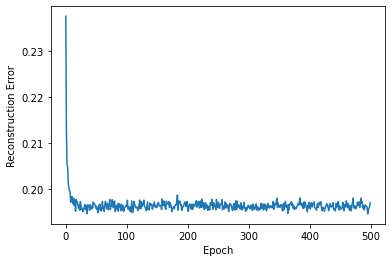

In [23]:
# Plot reconstruction errors
pd.Series(err).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")

In [24]:
#create the validation set
ratings_validation = np.zeros((n_uniq_users, n_uniq_papers))
for row in validation.itertuples():
    ratings_validation[row[5]-1, row[4]-1] = row[3]

# Predict ratings for validation set
inputValidation = ratings_validation
inputValidation = inputValidation.astype(np.float32)
finalOutput_validation, reconstructedOutput_validation, _ = rbm.rbm_output(inputValidation)

In [25]:
# Calculate MSE on validation set
predictionsArray = reconstructedOutput_validation
pred_validation = predictionsArray[ratings_validation.nonzero()].flatten()
actual_validation = ratings_validation[ratings_validation.nonzero()].flatten()
rbm_prediction = mean_squared_error(pred_validation, actual_validation)
print('Mean squared error using RBM prediction:', rbm_prediction)

Mean squared error using RBM prediction: 6.104477611940299
